In [1]:
import sys
sys.path.append('..')
from gammabayes.utils.event_axes import longitudeaxis, latitudeaxis, log10eaxis, longitudeaxistrue, latitudeaxistrue, log10eaxistrue
from gammabayes.likelihoods.instrument_response_funcs import irfs, log_psf
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

/Users/lpin0002/anaconda3/envs/testywesty/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


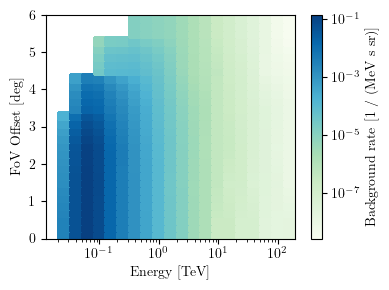

In [2]:
irfbkg = irfs['bkg']
plt.figure(figsize=(4,3))
irfbkg.to_2d().plot(add_cbar=True)
plt.tight_layout()

plt.savefig('Figures/irfbkg.pdf')
plt.show()

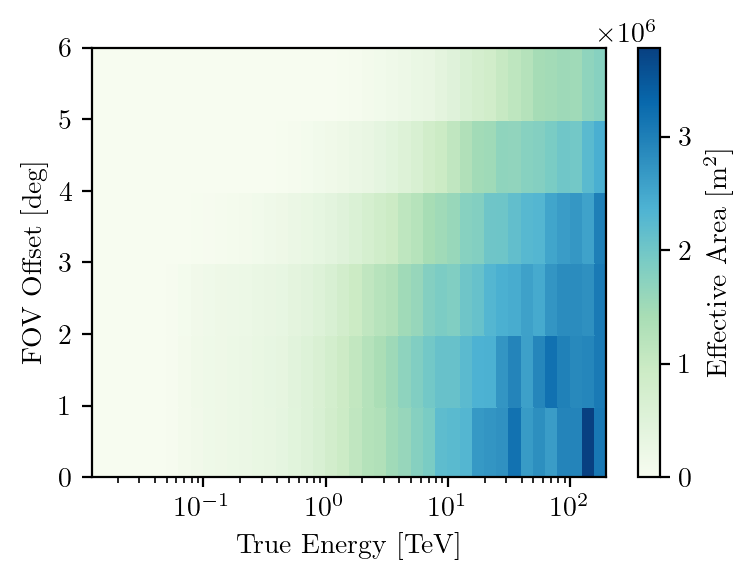

In [3]:
import numpy as np
from astropy import units as u

aeff = irfs['aeff']
edispfull = irfs['edisp']

offsetaxis = aeff.axes['offset'].center.value
energyaxis = aeff.axes['energy_true'].center.value

energymesh, offsetmesh = np.meshgrid(energyaxis, offsetaxis, indexing='ij')


plt.figure(figsize=(4,3), dpi=200)
pcol = plt.pcolormesh(energyaxis, 
               offsetaxis, 
               aeff.evaluate(energy_true=energymesh.flatten()*u.TeV, offset=offsetmesh.flatten()*u.deg).reshape(energymesh.shape).T,
               cmap='GnBu')
pcol.set_edgecolor('face')

plt.grid(False)
plt.xlabel('True Energy [TeV]')
plt.ylabel('FOV Offset [deg]')
plt.colorbar(label=r'Effective Area [m$^2$]')
plt.xscale('log')

plt.tight_layout()
plt.savefig('Figures/aeff.pdf')

plt.show()



['__abstractmethods__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_axes', '_data', '_fov_alignment', '_interpolate', '_interpolators', '_is_pointlike', '_mask_out_bounds', '_unit', 'axes', 'containment', 'containment_radius', 'cumsum', 'data', 'default_interp_kwargs', 'evaluate', 'evaluate_containment', 'evaluate_direct', 'evaluate_parameters', 'fov_alignment', 'from_hdulist', 'from_table', 'has_offset_axis', 'info', 'integral', 'integrate_log_log', 'interp_kwargs', 'interp_missing_data', 'is_allclose', 'is_pointlike', 'meta', 'normalize', 'pad', 'peek', 'plot_containment_radius', 'plot_containment_radius_vs_energy', 'plot_psf_vs_rad', 'quantity', 'read', 'req

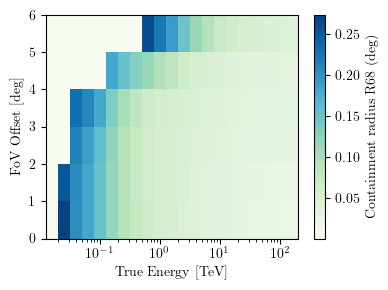

In [4]:
psffull = irfs['psf']
print(dir(psffull))
plt.figure(figsize=(4,3))
psffull.plot_containment_radius(add_cbar=True)
plt.tight_layout()
# plt.savefig('Figures/psf.pdf')
plt.show()

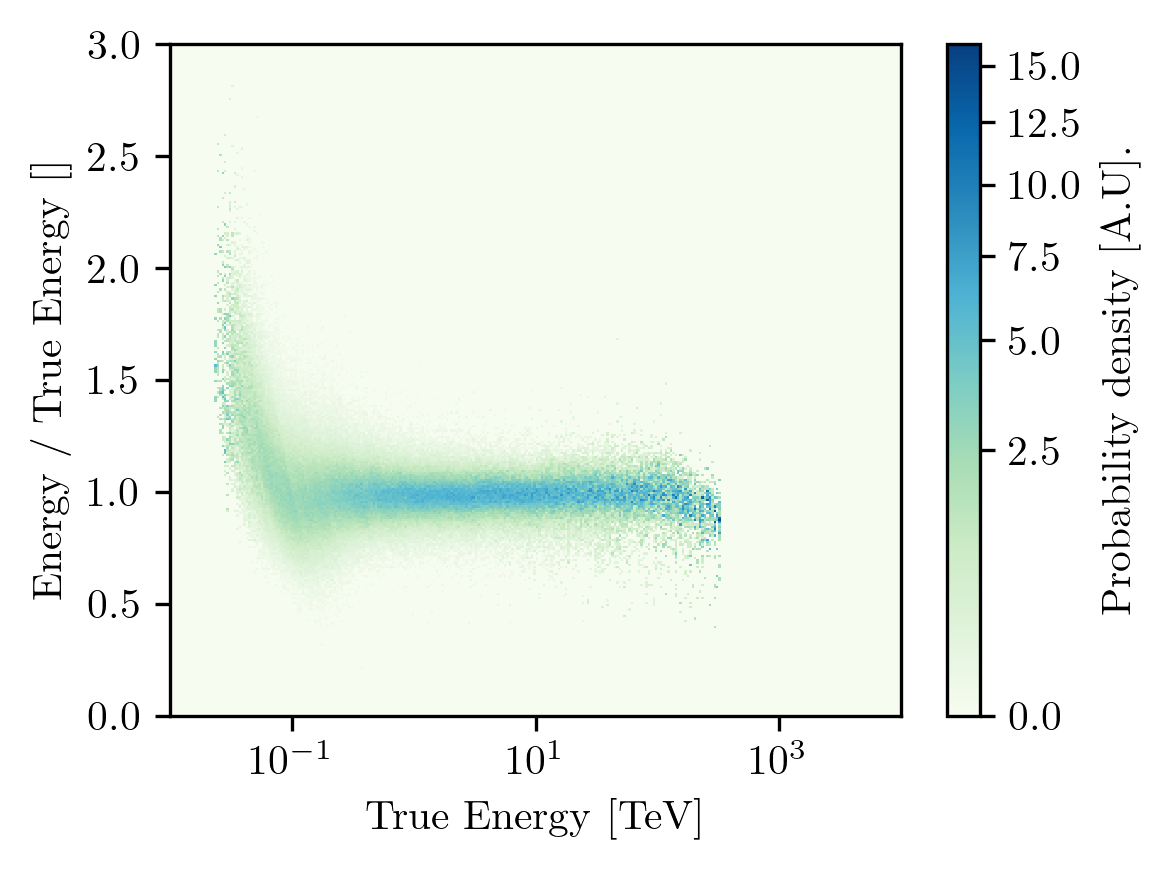

In [5]:
edisp = irfs['edisp']

plt.figure(figsize=(4,3), dpi=300)



edisp.plot_bias(add_cbar=True)

plt.tight_layout()
plt.savefig('Figures/edisp.png', dpi=400)

plt.show()

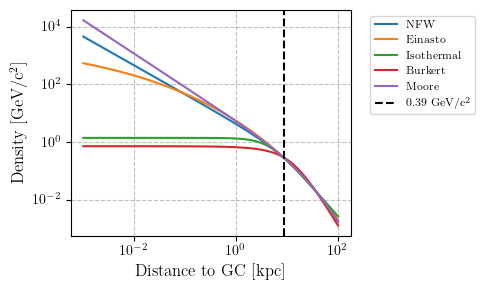

LOCAL_DENSITY: 0.3 GeV / cm3
DISTANCE_GC: 8.33 kpc


In [6]:
import numpy as np
import astropy.units as u

# %matplotlib inline
import matplotlib.pyplot as plt
from gammapy.astro.darkmatter import (
    profiles,
)


profiles.DMProfile.__subclasses__()



plt.figure(figsize=(5,3))
for profile in profiles.DMProfile.__subclasses__():
    p = profile()
    p.scale_to_local_density()
    radii = np.logspace(-3, 2, 100) * u.kpc
    plt.plot(radii, p(radii), label=p.__class__.__name__[:-7])

plt.loglog()
plt.axvline(8.5, linestyle="dashed", color="black", label=r"0.39 GeV/c$^2$")
plt.xlabel("Distance to GC [kpc]", size=12)
plt.ylabel(r"Density [GeV/c$^2$]", size=12)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', fontsize=8)
plt.grid(ls='--', c='grey', alpha=0.5)
plt.tight_layout()
plt.savefig('Figures/DM_Densities.pdf')
plt.show()

print("LOCAL_DENSITY:", profiles.DMProfile.LOCAL_DENSITY)
print("DISTANCE_GC:", profiles.DMProfile.DISTANCE_GC)

In [7]:
longitudeaxis, latitudeaxis = np.linspace(-0.5,0.5,200), np.linspace(-0.5,0.5,200)

lonmesh, latmesh = np.meshgrid(longitudeaxis, latitudeaxis, indexing='ij')

reconstructed_spatialcoord = np.array([lonmesh.flatten(), latmesh.flatten()])
logetrue = lonmesh.flatten()*0
truespatialcoord = np.array([lonmesh.flatten()*0, latmesh.flatten()*0])

psfvalues = log_psf(lonmesh.flatten(), latmesh.flatten(), logetrue.flatten(), lonmesh.flatten()*0, latmesh.flatten()*0).reshape(lonmesh.shape)

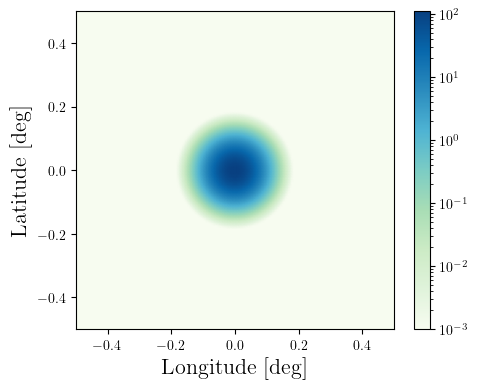

In [8]:
from matplotlib.colors import LogNorm
fig1, ax = plt.subplots(figsize=(5,4))

plt.pcolormesh(longitudeaxis, latitudeaxis, np.exp(psfvalues.T), 
               norm=LogNorm(vmin=1e-3), cmap='GnBu', shading='Gouraud')
ax.set_box_aspect(1)
plt.xlabel('Longitude [deg]', size=16)
plt.ylabel('Latitude [deg]', size=16)
plt.colorbar()
plt.tight_layout()
plt.savefig('Figures/psf.pdf')

plt.show()

In [49]:
from gammabayes.likelihoods.instrument_response_funcs import log_edisp
from gammabayes.utils.event_axes import makelogjacob
from scipy.integrate import cumtrapz
from tqdm import tqdm

log10eaxis = np.linspace(-1,2,1001)

log10eaxistrue_testvals = np.linspace(-1,2,2001)
from matplotlib.cm import get_cmap

cmap = get_cmap('winter')
diffvals = []
plt.figure(figsize=(5,4))
for idx, log10e_testval in tqdm(enumerate(log10eaxistrue_testvals), total=log10eaxistrue_testvals.shape[0]):
    edispvals = np.exp(log_edisp(log10eaxis, log10eaxis*0+log10e_testval, log10eaxis*0+2., log10eaxis*0+2.))
    plt.plot(10**log10eaxis, 
             edispvals,
             c=cmap(idx/log10eaxistrue_testvals.shape[0]),
             label=f"{10**log10e_testval} TeV")
    
    cumintvals = cumtrapz(y=edispvals, x=10**log10eaxis)
    cumintvals = cumintvals/cumintvals[-1]
    onesigma = 10**log10eaxis[np.where(cumintvals>0.6827)[0][0]]
    diffvals.append(np.abs(onesigma-10**log10e_testval)/10**log10e_testval)
    # print(f'Energy Res: {np.abs(10**log10e_testval-firstquartile)/10**log10e_testval}')
    plt.axvline(10**log10e_testval, ls='--', c=cmap(idx/log10eaxistrue_testvals.shape[0]))
    plt.axvline(onesigma, ls='--', c=cmap(idx/log10eaxistrue_testvals.shape[0]))

plt.ylim([1e-3, None])
plt.loglog()
# plt.legend(loc='lower right')
plt.xlabel('Reconstructed Energy [TeV]', size=16)
plt.tight_layout()
# plt.savefig('Figures/edisp.pdf')

plt.close()

/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_20948/1542595284.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('winter')


100%|██████████| 2001/2001 [00:38<00:00, 51.61it/s]


In [55]:
percentage = 90
numbins = 1/np.log10(1+np.percentile(diffvals, percentage))
numbins

66.6666666666657

/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_20948/3012821255.py:12: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim([0, 1000])


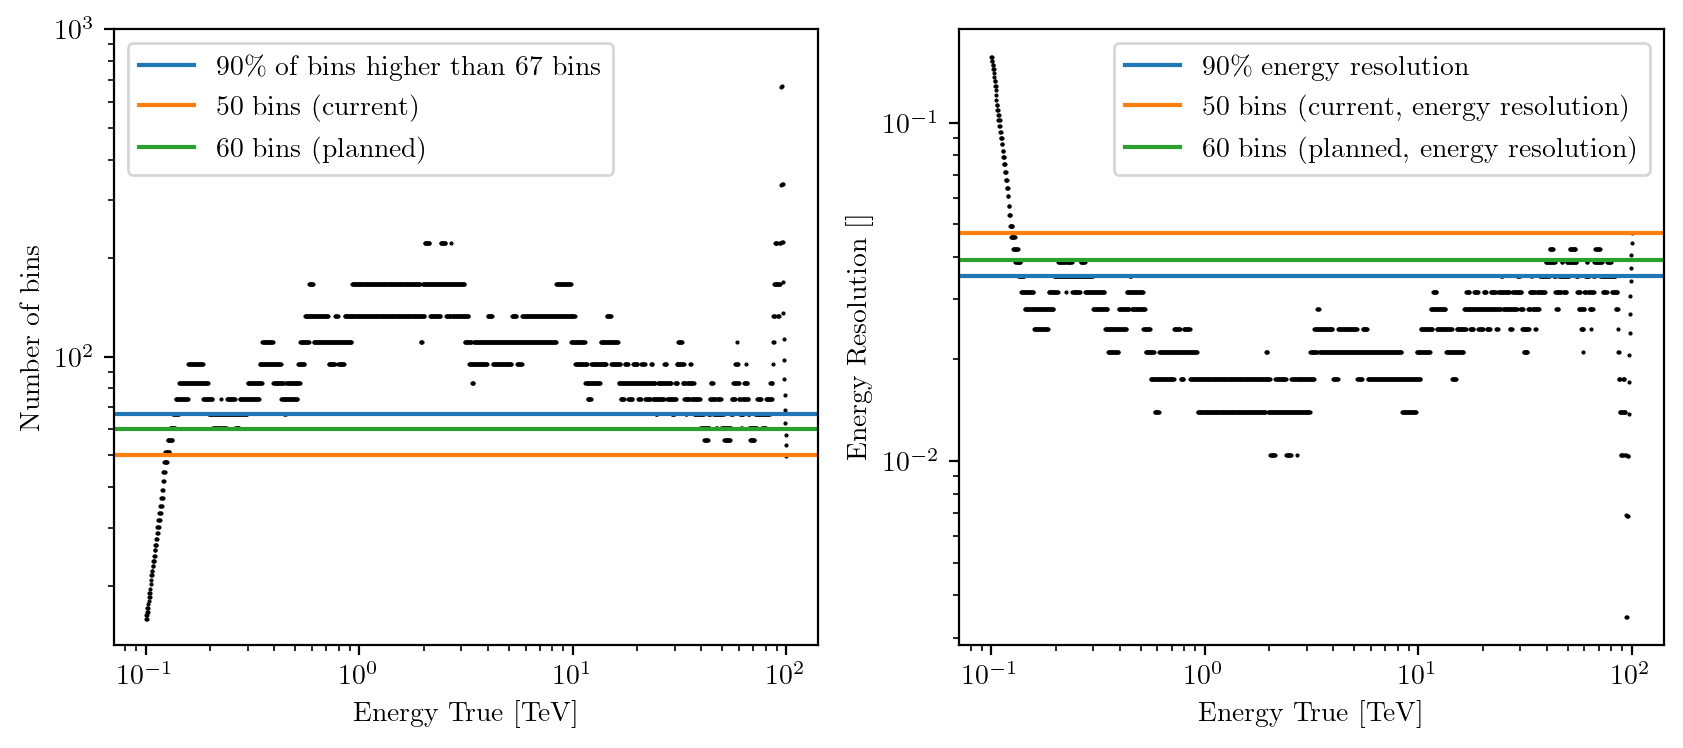

In [75]:
numwantedbins = 60
numcurrentbins = 50

plt.figure(figsize=(10,4), dpi=200)
plt.subplot(121)
plt.plot(10**log10eaxistrue_testvals, 1/np.log10(1+np.array(diffvals)), ls='None', marker='o', c='k', markersize=0.5)
plt.xscale('log')
plt.yscale('log')
plt.axhline(numbins, label=f'{percentage}\% of bins higher than '+f"{round(numbins)} bins")
plt.axhline(numcurrentbins, c='tab:orange', label=f"{numcurrentbins} bins (current)")
plt.axhline(numwantedbins, c='tab:green', label=f"{numwantedbins} bins (planned)")
plt.ylim([0, 1000])
plt.ylabel("Number of bins")
plt.xlabel(r'Energy True [TeV]')
plt.legend()


plt.subplot(122)
plt.plot(10**log10eaxistrue_testvals, np.array(diffvals), ls='None', marker='o', markersize=0.5, c='k')
plt.axhline(10**(1/numbins)-1, label=f'{percentage}\% energy resolution ')
plt.axhline(10**(1/numcurrentbins)-1, c='tab:orange', label=f"{numcurrentbins} bins (current, energy resolution)")
plt.axhline(10**(1/numwantedbins)-1, c='tab:green', label=f"{numwantedbins} bins (planned, energy resolution)")
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'Energy True [TeV]')
plt.ylabel(r'Energy Resolution []')
plt.legend()
